In [10]:
import torch
import torch.nn as nn
from torch import optim

from hednet import HedNet
from eval_hed import eval_net
from torch.utils.data import DataLoader, random_split
from utils.dataset import BasicDataset
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt

epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
val_percent = 0.2
img_scale = 1
dir_img = 'data_dm_overlapping/imgs/'
dir_mask = 'data_dm_overlapping/masks/'
batch_size = 5
lr = 0.0001

dataset = BasicDataset(dir_img, dir_mask, img_scale)
n_val = int(len(dataset) * val_percent)
#n_train = len(dataset) - n_val
#train, val = random_split(dataset, [n_train, n_val])
n_test = n_val
n_train = len(dataset) - n_val - n_test
train, val, test = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

In [4]:
#len(train_loader)
print(f'Total images: {len(dataset)}')
print(f'Training images: {len(train)}')
print(f'Validation images: {len(val)}')
print(f'Test images: {len(test)}')

Total images: 3000
Training images: 1800
Validation images: 600
Test images: 600


In [5]:
net = HedNet(n_channels=3, n_classes=1, bilinear=False)
net.to(device=device)

#summary(net, (3,256,256))

HedNet(
  (coordconv): CoordConv2d(
    3, 32, kernel_size=(1, 1), stride=(1, 1)
    (addcoords): AddCoords()
    (conv): Conv2d(5, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (inc): DoubleConv(
    (rsblock1): RSBlock(
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sb): ChannelSELayer(
        (fc1): Linear(in_features=32, out_features=16, bias=True)
        (fc2): Linear(in_features=16, out_features=32, bias=True)
        (relu): ReLU()
        (sigmoid): Sigmoid()
      )
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (rsblock2): RSBlock(
      (relu): ReLU(inplace=Tru

In [6]:
criterion = nn.MSELoss().cuda()

#optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

train_losses = []
val_losses = []

side = 5

for epoch in range(epochs):
    net.train()
    
    epoch_loss = 0

    #
    with tqdm(total=n_train, desc=f'Train Epoch {epoch+1}/{epochs}') as pbar:
        for batch in train_loader:
            imgs, true_masks = batch['image'], batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)

            masks_pred = net(imgs)[side]
            #masks_pred = net(imgs)
            
            loss = criterion(masks_pred, true_masks)
            #loss1 = criterion(masks_pred[0], true_masks)
            #loss2 = criterion(masks_pred[4], true_masks)
            #loss = loss1 + loss2
            #avg_loss = loss.item()/2
            #epoch_loss += avg_loss * imgs.size(0)
            epoch_loss += loss.item() * imgs.size(0)

            #
            #print('size(0): ', imgs.size(0))
            #print('shape[0]: ', imgs.shape[0])
            #pbar.set_postfix(**{'avg loss (batch)': avg_loss})
            pbar.set_postfix(**{'loss (batch)': loss.item()})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
            pbar.update(imgs.shape[0])
            
        #pbar.write(f'Train Loss: {epoch_loss/len(train)}')

    train_losses.append(epoch_loss/len(train))
    #print(f'Train Loss: {epoch_loss/len(train)}')
    
    net.eval()
    epoch_loss = 0
    
    #
    with tqdm(total=n_val, desc=f'Val Epoch {epoch+1}/{epochs}') as pbar:
        for batch in val_loader:
            imgs, true_masks = batch['image'], batch['mask']
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)

            with torch.no_grad():
                #mask_pred = net(imgs)
                mask_pred = net(imgs)[side]
                #loss1 = criterion(mask_pred[0], true_masks)
                #loss2 = criterion(mask_pred[4], true_masks)
                loss = criterion(mask_pred, true_masks)
            
            #loss = loss1 + loss2
            #avg_loss = loss.item()/2
            #epoch_loss += avg_loss * imgs.size(0)
            epoch_loss += loss.item() * imgs.size(0)
            
            # ...
            #pbar.set_postfix(**{'avg loss (batch)': avg_loss})
            pbar.set_postfix(**{'loss (batch)': loss.item()})
            pbar.update(imgs.shape[0])
            
        #pbar.write(f'Val Loss: {epoch_loss/len(val)}')
        
    scheduler.step(epoch_loss/len(val))
    val_losses.append(epoch_loss/len(val))
    #print(f'Val Loss: {epoch_loss/len(val)}')

print(f'The best MSE: {min(val_losses)}')

Val Epoch 20/20: 100%|██████████| 600/600 [00:05<00:00, 107.10it/s, loss (batch)=0.0011]  

The best MSE: 0.0009957556865022828


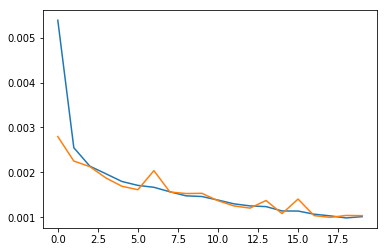

In [7]:

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [8]:
torch.save(net.state_dict(), 'MODEL.pth')
print(f'modelo guardado')

modelo guardado


output.shape = torch.Size([1, 1, 256, 256])
output.shape = torch.Size([1, 256, 256])


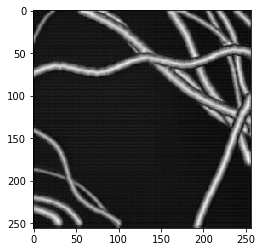

-0.020979181


True

In [55]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

side = 4
net.load_state_dict(torch.load('MODEL.pth'))

net.eval()

full_img = Image.open('_dm_img.png')
img = torch.from_numpy(BasicDataset.preprocess(full_img, 1))
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(img)[side]

print(f'output.shape = {output.shape}')

output = output.squeeze(0)

print(f'output.shape = {output.shape}')

#print(f'full_img.size[1] = {full_img.size[0]}')

tf = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(full_img.size[1]),
        transforms.ToTensor()
    ]
)


mask = output.squeeze().cpu().numpy()

plt.imshow(mask, cmap='gray')
plt.show()

print(mask.min())

mask *= (255.0/mask.max())
cv2.imwrite('prediction.png', mask)


torch.Size([5, 3, 256, 256])
ground truth


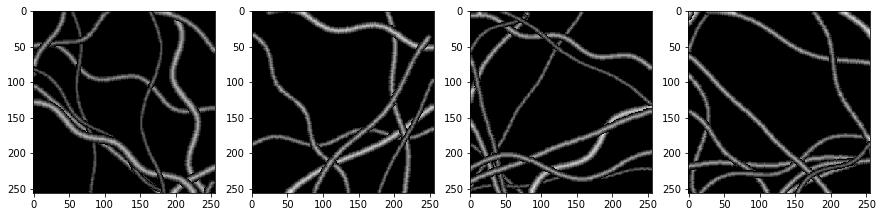

predictions


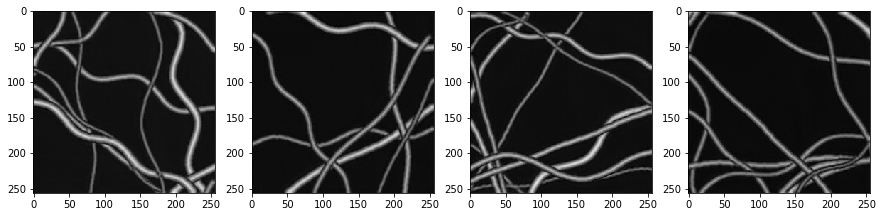

In [56]:
test_images = enumerate(test_loader)

q = next(test_images)

print(q[1]['image'].shape)

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(q[1]['mask'][i][0], cmap='gray')

print('ground truth')
plt.show()

side = 5
with torch.no_grad():
    output = net(q[1]['image'])[side]
    
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(output.cpu()[i][0], cmap='gray')
    
print('predictions')
plt.show()

In [69]:
import numpy as np

pred = output.cpu()[0][0].numpy()

pred *= (255.0/pred.max())

pred = np.clip(pred, 0, 255)

print(pred.max())
print(pred.dtype)

cv2.imwrite('prediction2.png', pred.astype(np.uint8))

255.0
float32


True

In [3]:
def train_skeleton_net(side):
    
    print(f"Training at side: {side}")
    
    net = HedNet(n_channels=3, n_classes=1, bilinear=False)
    net.to(device=device)

    #print(f'len={len(val_loader)}')
    criterion = nn.MSELoss()

    #optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0

        #
        with tqdm(total=n_train, desc=f'Train Epoch {epoch+1}/{epochs}') as pbar:
            for batch in train_loader:
                imgs, true_masks = batch['image'], batch['mask']

                imgs = imgs.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.float32)

                masks_pred = net(imgs)[side]
                loss = criterion(masks_pred, true_masks)

                epoch_loss += loss.item() * imgs.size(0)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(imgs.shape[0])

        train_losses.append(epoch_loss/len(train))
        #print(f'Train Loss: {epoch_loss/len(train)}')

        net.eval()
        epoch_loss = 0

        #
        with tqdm(total=n_val, desc=f'Val Epoch {epoch+1}/{epochs}') as pbar:
            for batch in val_loader:
                imgs, true_masks = batch['image'], batch['mask']
                imgs = imgs.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.float32)

                with torch.no_grad():
                    mask_pred = net(imgs)[side]
                    loss = criterion(mask_pred, true_masks)

                epoch_loss += loss.item() * imgs.size(0)

                # ...
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                pbar.update(imgs.shape[0])

            #pbar.write(f'Val Loss: {epoch_loss/len(val)}')
        val_losses.append(epoch_loss/len(val))
        
    print(f'The best MSE at side {side+1}: {min(val_losses)}')
        
    return train_losses, val_losses

Training at side: 4


Val Epoch 20/20: 100%|██████████| 600/600 [00:05<00:00, 106.34it/s, loss (batch)=0.000838]


The best MSE at side 5: 0.0008258116317544288


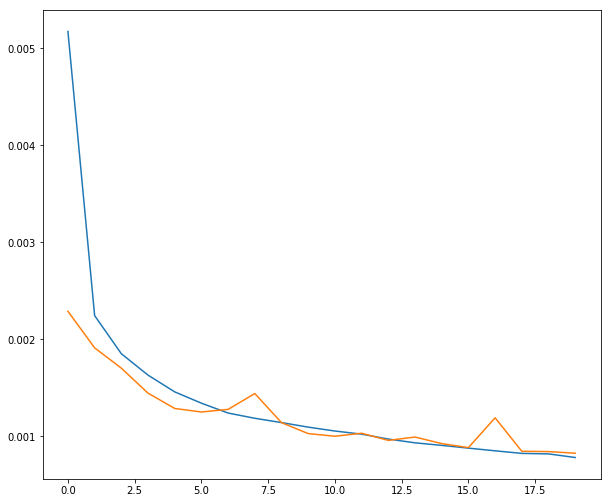

In [4]:
plt.figure(figsize=(10,50))
for side in range(4,5):
    train_losses, val_losses = train_skeleton_net(side)
    
    plt.subplot(5, 1, side+1)
    plt.plot(train_losses)
    plt.plot(val_losses)
plt.show()